In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_emb_crop_mask as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_embedding_128 import Embdding_128 as model_emb
from models.model_embedding_128_mask import Embdding_128 as model_emb_mask


#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3, 4, 5, 6, 7"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
torch.cuda.device_count()

3

In [3]:
BATCH_SIZE = 64
cuda = torch.cuda.is_available()
IMAGE_SIZE = 224

In [4]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['apple', 'orange', 'donut'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [5]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)
data_loader = cocoloader

loading annotations into memory...
Done (t=14.87s)
creating index...
index created!


orange,donut,donut,apple,

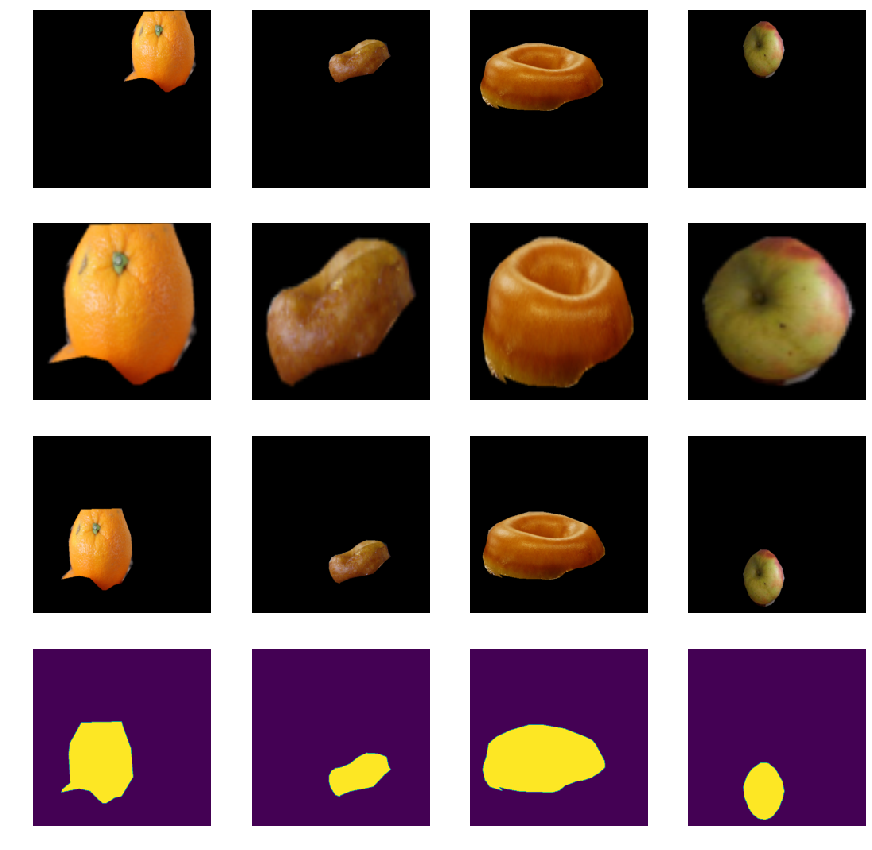

In [6]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
for objs, objs_crop, objs_tran, mask, nms in cocoloader:
#     print(im.shape)
    for j, image in enumerate(objs[0:4]):
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
    i += 1    
    for j, image in enumerate(objs_crop[0:4]):
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
    i += 1
    for j, image in enumerate(objs_tran[0:4]):
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
    i += 1
    for j, image in enumerate(mask[0:4]):
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(image.numpy()[0])
        axarr[i, j].axis('off')
    break
for nm in nms[0:4]:
    print(nm + ',', end = '')
    

In [7]:
def deTanh(x):
    return x.add(1).mul(0.5)
def Tanhize(x):
    return x.mul(2).add(-1)

In [14]:
model_obj = model_emb(IMAGE_SIZE)
if cuda:
    model_obj.cuda()
num_epochs = 10000
d2 =  {str(k)[7:]:v for k,v in torch.load('weight_emb_crop/weight_2000.pkl').items()}
model_obj.load_state_dict(d2)
model_obj = nn.DataParallel(model_obj)
model_obj.batch_size = BATCH_SIZE
model_obj.eval()

model_mask = model_emb_mask(IMAGE_SIZE)
if cuda:
    model_mask.cuda()
num_epochs = 10000
d2 =  {str(k)[:]:v for k,v in torch.load('weight_emb_mask/weight_2000.pkl').items()}
model_mask.load_state_dict(d2)
model_mask = nn.DataParallel(model_mask)
model_mask.batch_size = BATCH_SIZE
model_mask.eval()

imgs_emb = [] #torch.zeros((512, 3, 224, 224)).cuda()
emb_obj_vec =  [] #torch.zeros((512, 128)).cuda()
emb_mask_vec = [] #torch.zeros((512, 128)).cuda()
class_emb = [] #torch.zeros((512, 3)).cuda()
masks = []
# imgs_emb_V2 = torch.tesnor([])

for i, (objs, objs_crop, objs_tran, mask, nms) in enumerate(cocoloader):

    if cuda:
        objs_crop = Tanhize(Variable(objs_crop).cuda())
        mask = Tanhize(Variable(mask).cuda())
        objs_tran = Tanhize(Variable(objs_tran).cuda())
    else:
        objs_crop = Tanhize(Variable(objs_crop))
        mask = Tanhize(Variable(mask))
        objs_tran = Tanhize(Variable(objs_tran))
        
    z_obj, x_hat_obj = model_obj(objs_crop)
    z_mask, x_hat_mask = model_mask(mask)
#     print(z.shape)
#     print(x.shape)
#     break
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    print(end)
    imgs_emb.extend(objs_tran.data.cpu().numpy())
    emb_obj_vec.extend(z_obj.data.cpu().numpy())
    emb_mask_vec.extend(z_mask.data.cpu().numpy())
    masks.extend(mask.data.cpu().numpy())
#     emb_obj_vec[start : end] = z_obj
#     emb_mask_vec[start : end] = z_mask
#     masks[start : end] = mask
    
    for j, nm in enumerate(nms):
        if nm == 'apple':
            class_emb.append([1, 0, 0])
        if nm == 'orange':
            class_emb.append([0, 1, 0])
        if nm == 'donut':
            class_emb.append([0, 0, 1])
#     nms_emb[start : end] = nms
    
    

# torch.save(imgs_emb, 'emb_info_obj_mask/imgs.pt')
# torch.save(emb_obj_vec, 'emb_info_obj_mask/emb_obj_vec.pt')
# torch.save(emb_mask_vec, 'emb_info_obj_mask/emb_mask_vec.pt')
# torch.save(class_emb, 'emb_info_obj_mask/class_embeddings.pt')
# torch.save()
# print(nms[63])
# print(class_emb[511])
    

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088


In [15]:
print(
torch.tensor(imgs_emb).shape, 
torch.tensor(emb_obj_vec).shape,  
torch.tensor(emb_mask_vec).shape, 
np.array(class_emb).shape, 
torch.tensor(masks).shape)

torch.Size([1068, 3, 224, 224]) torch.Size([1068, 128]) torch.Size([1068, 128]) (1068, 3) torch.Size([1068, 1, 224, 224])


In [16]:
imgs_emb     = torch.tensor(imgs_emb) 
emb_obj_vec  = torch.tensor(emb_obj_vec)  
emb_mask_vec = torch.tensor(emb_mask_vec) 
class_emb    = torch.tensor(class_emb) 
masks        = torch.tensor(masks)

torch.save(imgs_emb, 'emb_info_obj_mask/imgs.pt')
torch.save(emb_obj_vec, 'emb_info_obj_mask/emb_obj_vec.pt')
torch.save(emb_mask_vec, 'emb_info_obj_mask/emb_mask_vec.pt')
torch.save(class_emb, 'emb_info_obj_mask/class_embeddings.pt')
# torch.save()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_emb_crop_mask as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_embedding_128 import Embdding_128 as model_emb
from models.model_embedding_128_mask import Embdding_128 as model_emb_mask


#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3, 4, 5, 6, 7"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [18]:
def reshapeTensor(images, new_size):
    import torch
    from torchvision import transforms
    p = transforms.Compose([transforms.Scale((48,48))])
    from PIL import Image
    new_imgs = []
    for img in imgs:
        x = torch.tensor(img)
        x = transforms.ToPILImage()(x)
        x = transforms.functional.resize(x,new_size)
        new_imgs.append(transforms.ToTensor()(x).numpy())

    print(np.array(new_imgs).shape)
    return np.array(new_imgs)

In [19]:
def deTanh(x):
    return x.add(1).mul(0.5)
def Tanhize(x):
    return x.mul(2).add(-1)

In [20]:
# imgs = torch.load( 'emb_info/imgs.pt').data.cpu().numpy()
# imgs = deTanh(torch.tensor(imgs)).data.numpy() # reshape to -1 to 1 
# embeddings = torch.load('emb_info/embeddings.pt').data.cpu().numpy()
# _class = torch.load( 'emb_info/class_embeddings.pt').data.cpu().numpy()





imgs       = deTanh(torch.load('emb_info_obj_mask/imgs.pt')).data.cpu().numpy()
mask_embed = torch.load('emb_info_obj_mask/emb_obj_vec.pt').data.cpu().numpy()
obj_embed  = torch.load('emb_info_obj_mask/emb_mask_vec.pt').data.cpu().numpy()
_class     = torch.load('emb_info_obj_mask/class_embeddings.pt').data.cpu().numpy()

In [21]:
print(imgs.shape, mask_embed.shape,obj_embed.shape, _class.shape)
print(np.max(imgs), np.min(imgs))


(1068, 3, 224, 224) (1068, 128) (1068, 128) (1068, 3)
1.0 0.0


In [22]:
embeddings = np.hstack((mask_embed,obj_embed))

In [23]:
imgs = Tanhize(torch.tensor(reshapeTensor(imgs, new_size = 64))).data.numpy()   # reshape to 64 for all images
embeddings = torch.nn.functional.pad(torch.tensor(embeddings),(0,768)).numpy()  # reshape embedding to 1024
# imgs = Tanhize(torch.tensor(imgs)).data.numpy() # reshape to -1 to 1 

/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


(1068, 3, 64, 64)


In [24]:
print(imgs.shape, embeddings.shape,_class.shape)
print(np.max(imgs), np.min(imgs))

(1068, 3, 64, 64) (1068, 1024) (1068, 3)
1.0 -1.0


In [25]:
import os
from os.path import join, isfile
import numpy as np
import h5py
from glob import glob
# from torch.utils.serialization import load_lua
from PIL import Image
import yaml
import io
import pdb

In [26]:
# with open('config.yaml', 'r') as f:
# 	config = yaml.load(f)
datasetDir = '/scratch/cluster-share/linzhe/text2image/flowersV8.hdf5'

f = h5py.File(datasetDir, 'w')
train = f.create_group('train')
valid = f.create_group('valid')
test = f.create_group('test')

# for _class in sorted(os.listdir(embedding_path)):
# 	split = ''
# 	if _class in train_classes:
# 		split = train
# 	elif _class in val_classes:
# 		split = valid
# 	elif _class in test_classes:
# 		split = test

In [27]:

# img = []

dt = h5py.special_dtype(vlen=str)
split = train

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data=str(_class[c]))
    ex.create_dataset('txt', data='object_'+str(c), dtype=dt)
# f.close()


In [28]:
# img = []

dt = h5py.special_dtype(vlen=str)
split = test

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data=str(_class[c]))
    ex.create_dataset('txt', data='object_'+str(c), dtype=dt)
# f.close()

In [29]:
# img = []

dt = h5py.special_dtype(vlen=str)
split = valid

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data=str(_class[c]))
    ex.create_dataset('txt', data='object_'+str(c), dtype=dt)
# f.close()

In [30]:
f.close()